Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [3]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset
import utils

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

In [4]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [5]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-merge_ALL.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')

Columns (186,200) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
print(df.columns.to_list())

['Unnamed: 0', 'PropertyKey_ID', 'Deal_id', 'Property_id', 'Status_tx', 'Status_dt', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Deal_Update_dt', 'Property_Update_dt', 'Excess_Land_Potential_fg', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'MaxChanged_dt', 'year', 'age_bracket', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'PSF/PPU', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb', 'YearBlt_new', 'age_left', 'YearBlt', 'YearBlt_new2', 'age2', 'YearBlt2', 'residential_type', 'geometry', 'i

## Prediction

In [7]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

Here we deliberately predict "age_right" the age variable from EUBUCCO, given that for NLD it is 100% available and therefore has higher coverage than YearBlt from RCA. YearBlt and age_right have a correlation of 0.6 To make results more comparable, in the RCA only version, I revert to using YearBlt instead of YearBlt_new2, given that YearBlt_new2 has a correlation of only 0.22 with age_right from EUBUCCO.

2024-01-24 13:16:40,598 | INFO : Dataset length: 7407
2024-01-24 13:16:40,604 | INFO : Dataset allocated memory: 11 MB
2024-01-24 13:16:40,616 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-8653e6a6.abort.
2024-01-24 13:16:40,617 | INFO : Dataset standard deviation: 139.22544289457545
2024-01-24 13:16:40,618 | INFO : Dataset mean age: 1953.791683542595
2024-01-24 13:16:40,619 | INFO : Training dataset length: 5925
2024-01-24 13:16:40,619 | INFO : Test dataset length: 1482
2024-01-24 13:16:40,734 | INFO : Features selected are: ['PropertyKey_ID', 'Deal_id', 'Property_id', 'Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPric

Applying categorical_to_int_byList to variables: ['Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'residential_type']
Applying convert_to_double_byList to variables: ['PropertyKey_ID', 'Deal_id', 'Property_id', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'PSF/PPU', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb', 'residential_type']


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
2024-01-24 13:16:43,525 | INFO : Energy need for heating in kWh/(m²a) R2: 0.6875
2024-01-24 13:16:43,526 | INFO : Energy need for heating in kWh/(m²a) MAPE: 0.2768
2024-01-24 13:16:43,526 | INFO : Energy need for heating in kWh/(m²a) MAE: 19.46
2024-01-24 13:16:43,526 | INFO : Energy need for heating in kWh/(m²a) RMSE: 33.40


MAE: 13.94 y
RMSE: 19.08 y
R2: 0.5077
Energy need for heating in kWh/(m²a) R2: 0.6875
Energy need for heating in kWh/(m²a) MAPE: 0.2768


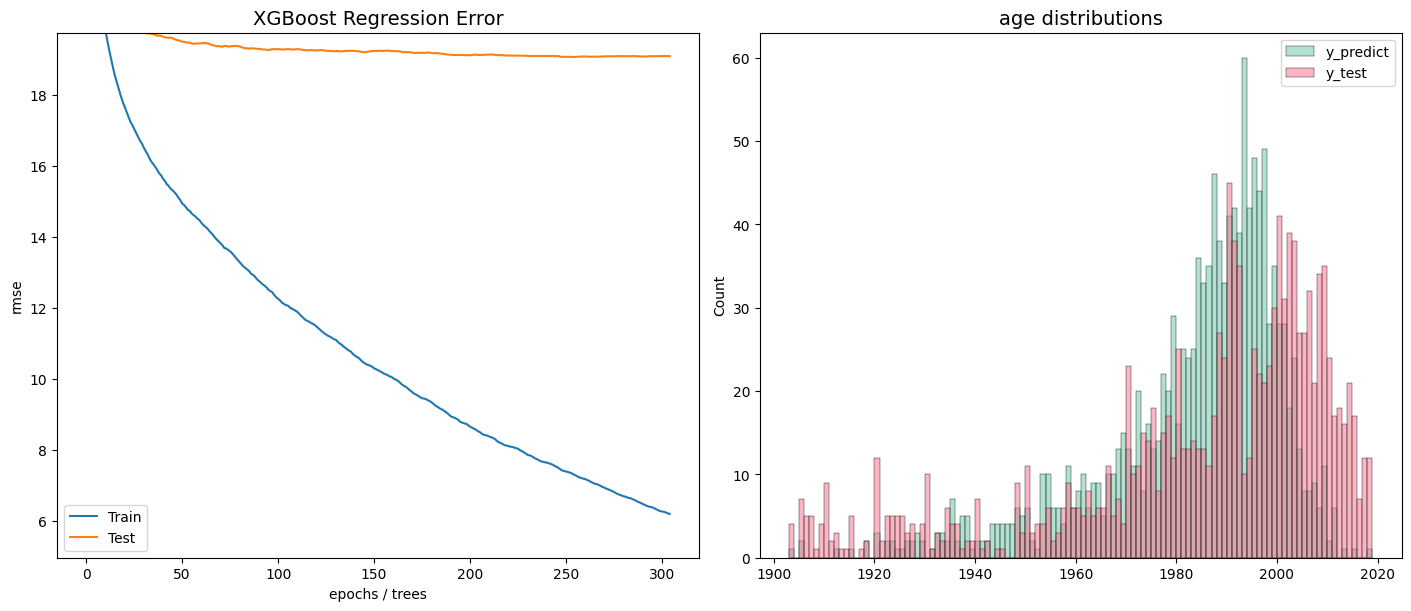

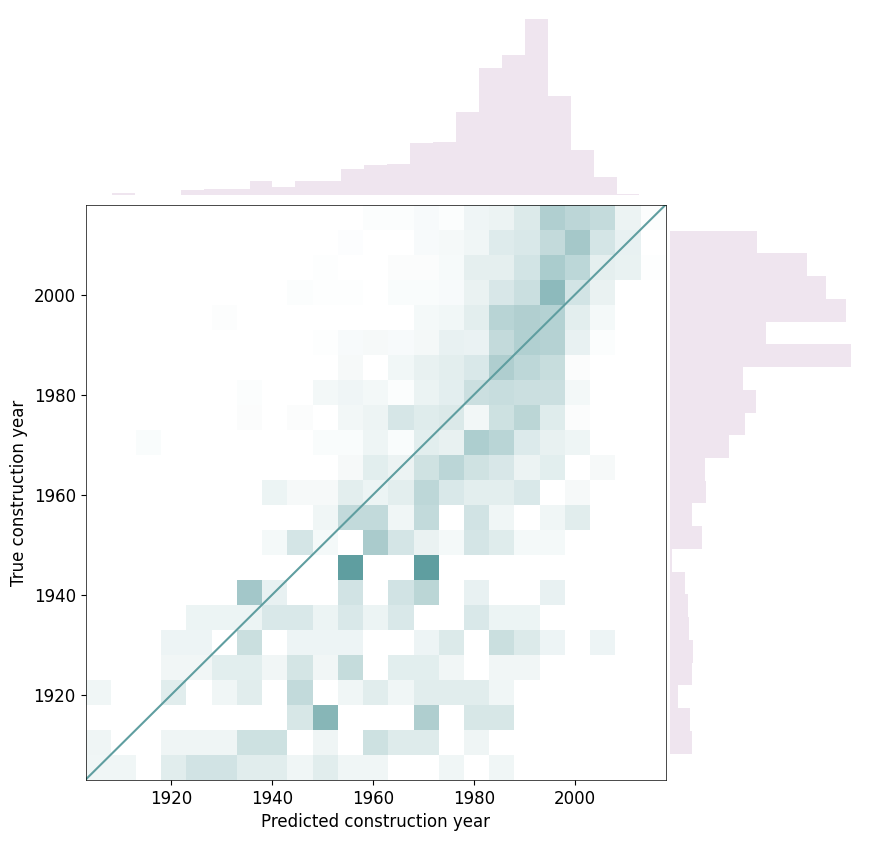

In [8]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
)

predictor.evaluate()


In [ ]:
def age_bins(y, bin_size=1):
    # lower bound inclusive
    min_age = math.floor(y[dataset.AGE_ATTRIBUTE].min())
    # upper bound inclusive for histogram plotting, exclusive for categorizing variables
    max_age = math.ceil(y[dataset.AGE_ATTRIBUTE].max())
    return list(range(min_age, max_age + 1))[0::bin_size]

In [14]:
import math
min_age = 1900
max_age = math.ceil(df[dataset.AGE_ATTRIBUTE].max())

Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.


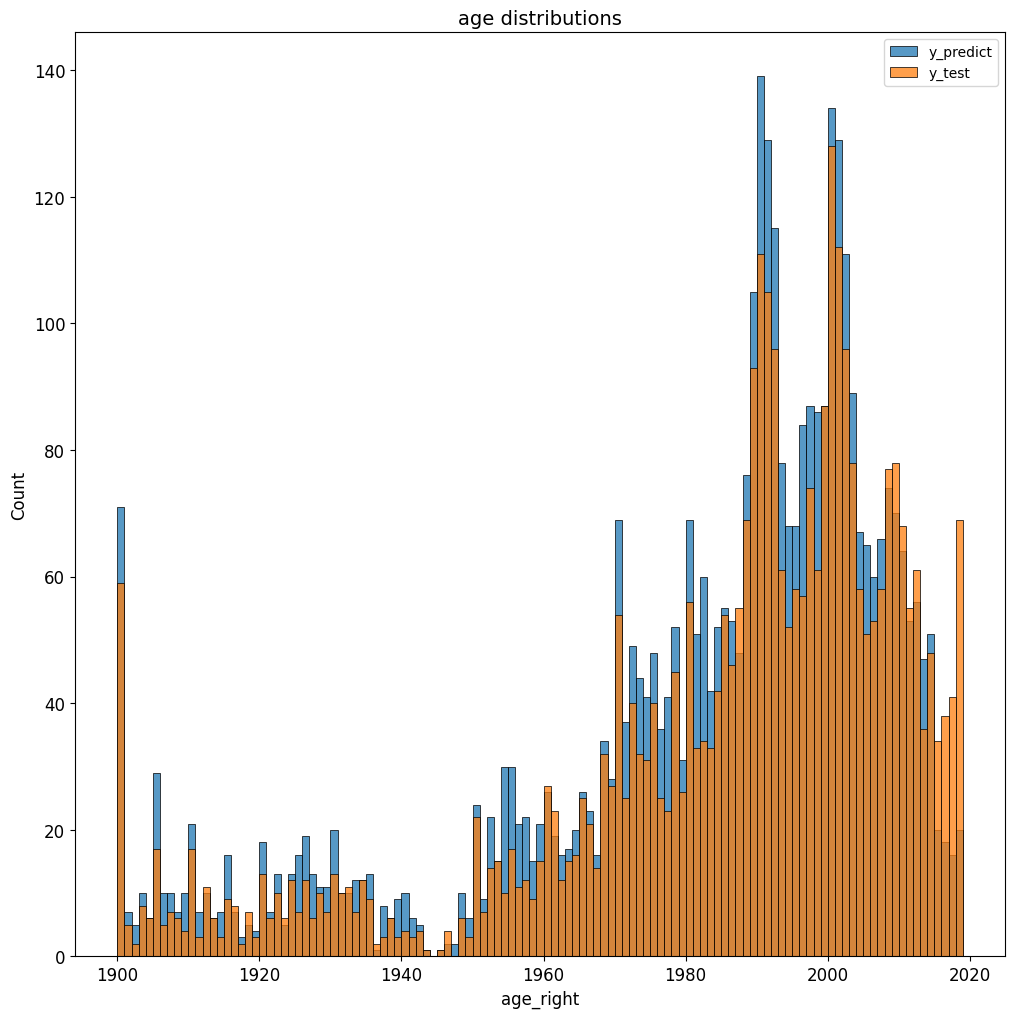

In [18]:
#YearBlt is y_test
visualizations.plot_histogram(df['YearBlt'], df['age_right'], bins=list(range(min_age, max_age + 1))[0::1])

In [40]:
from sklearn import metrics
df_filtered = df[df['YearBlt'].notna()]
print('MAE: {:.2f} y'.format(metrics.mean_absolute_error(df_filtered['age_right'], df_filtered['YearBlt'])))
print('RMSE: {:.2f} y'.format(np.sqrt(metrics.mean_squared_error(df_filtered['age_right'], df_filtered['YearBlt']))))
print('R2: {:.4f}'.format(metrics.r2_score(df_filtered['age_right'], df_filtered['YearBlt'])))


MAE: 27.27 y
RMSE: 118.00 y
R2: 0.3802


In [37]:
df_filtered['age_right']

4       1990.0
5       1997.0
6       1978.0
7       1986.0
10      2008.0
         ...  
4555    1981.0
4556    2002.0
4557    1965.0
4558    1989.0
4559    2007.0
Name: age_right, Length: 3982, dtype: float64

In [38]:
df_filtered['YearBlt']

4       1990.0
5       1998.0
6       1978.0
7       1991.0
10      2009.0
         ...  
4555    1981.0
4556    2002.0
4557    2020.0
4558    1989.0
4559    2007.0
Name: YearBlt, Length: 3982, dtype: float64

### Classification

2024-01-24 13:16:58,787 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2024-01-24 13:16:58,788 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2024-01-24 13:16:58,799 | INFO : Dataset length: 7407
2024-01-24 13:16:58,805 | INFO : Dataset allocated memory: 11 MB
2024-01-24 13:16:58,817 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-e764d61b.abort.
2024-01-24 13:16:58,818 | INFO : Training dataset length: 5925
2024-01-24 13:16:58,818 | INFO : Test dataset length: 1482
2024-01-24 13:16:58,820 | INFO : Test cities: ['Lagny-le-Sec' 'Valframbert' 'Alkmaar' 'Carcassonne' 'Hilversum'
 'Heerlen' 'Barendrecht' 'Utrecht' 'Groningen' 'Getafe' 'Doetinchem'
 'Amsterdam' 'Charols' 'Ontigola' 'Sliedrecht' 'Barcelona' 'Den Bosch'
 'Uden' 'The Hague' 'Palma de Mallorca' 'Oud-Beijerland' 'Apeldoorn'
 'Nanteuil-les-Meaux' 'Helmond' 'Madrid'

Applying categorical_to_int_byList to variables: ['Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'residential_type']
Applying convert_to_double_byList to variables: ['PropertyKey_ID', 'Deal_id', 'Property_id', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'PSF/PPU', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb', 'residential_type']
Classification report:
               precision    recall  f1-score  

FixedFormatter should only be used together with FixedLocator


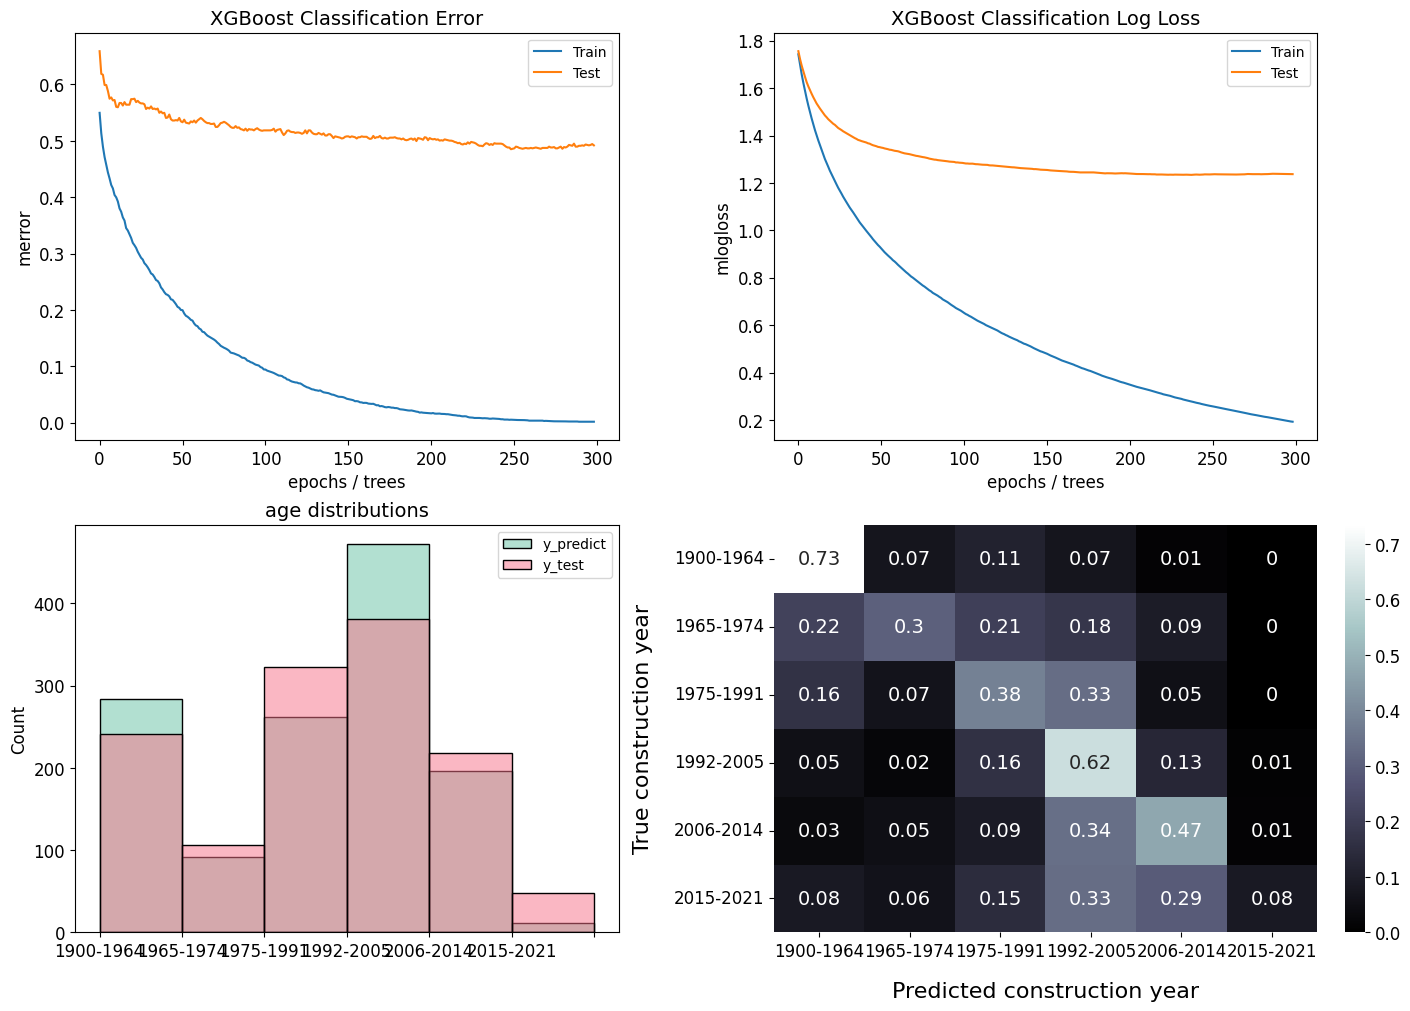

In [9]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [ ]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_filtered
gc.collect()